In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification 
from sklearn.metrics import accuracy_score

import pickle

In [ ]:
#X,y -> raw, target-> y, drop species 
# split into training and testing (test size=0.2)
# train the model with Logistic Regression log_model
#create Y_pred with predicted values 
#check accuracy score

Dataset size after preprocessing: (8000, 6)
Accuracy: 0.773125

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      1230
           1       0.68      0.04      0.07       370

    accuracy                           0.77      1600
   macro avg       0.73      0.52      0.47      1600
weighted avg       0.75      0.77      0.68      1600



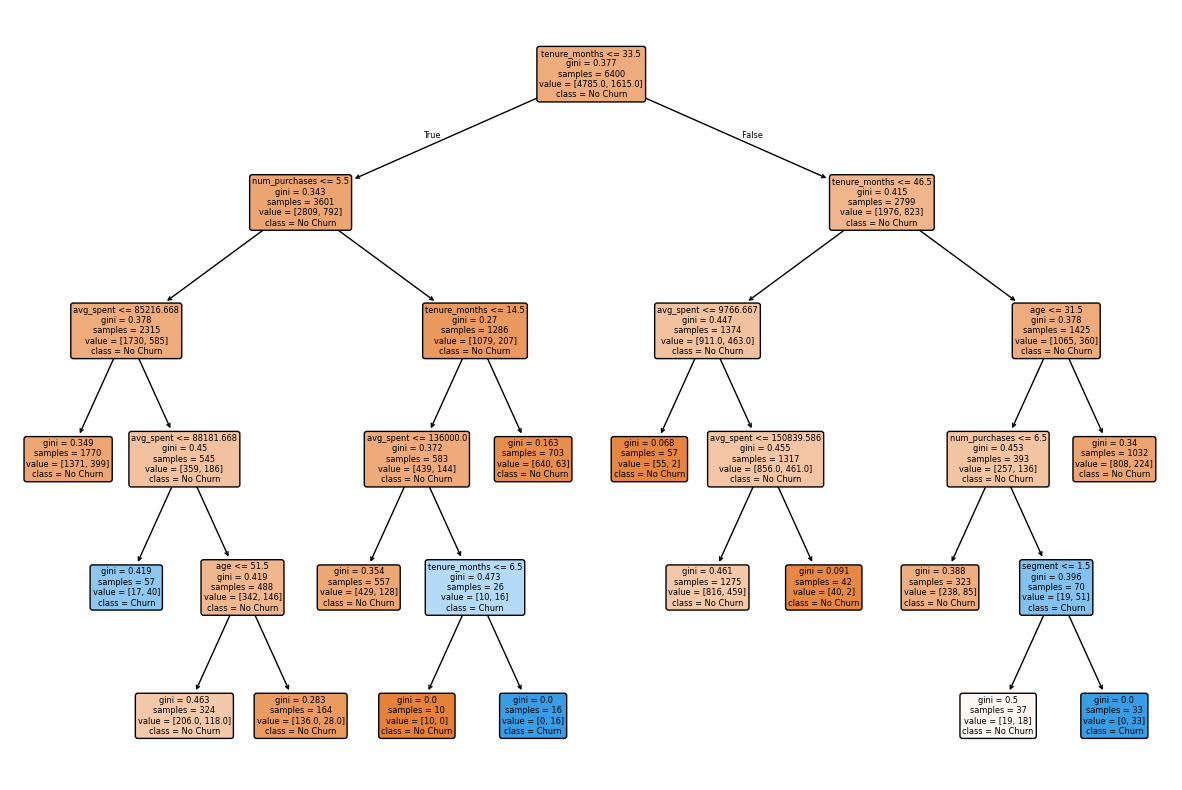

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("customer_intelligence_dataset.csv")

# Encode categorical features
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Encode segment using LabelEncoder
le = LabelEncoder()
df['segment'] = df['segment'].astype(str)  # ensure string
df['segment'] = le.fit_transform(df['segment'])

# Ensure churn is numeric
df['churn'] = df['churn'].map({0: 0, 1: 1})

# Feature engineering
df['num_purchases'] = df.groupby('customer_id')['sale_id'].transform('count')
df['avg_spent'] = df.groupby('customer_id')['total_value'].transform('mean')

# Feature set (without sentiment and region)
features = ["age", "gender", "segment", "tenure_months", 
            "num_purchases", "avg_spent"]

# Replace NaN with 0
df_model = df[features + ["churn"]].fillna(0)

X = df_model[features]
y = df_model["churn"]

# Check dataset size
print("Dataset size after preprocessing:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision tree with pre-pruning
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,             # limit tree depth
    min_samples_split=20,    # min samples to split
    min_samples_leaf=10,     # min samples at leaf
    max_leaf_nodes=15,       # limit max leaves
    random_state=42
)

dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot tree
plt.figure(figsize=(15, 10))
plot_tree(dt, feature_names=features, class_names=["No Churn", "Churn"], filled=True, rounded=True)
plt.show()



In [17]:
with open("../models/logistic_model.pkl", "wb") as f:
    pickle.dump(log_model,f)

Dataset size after preprocessing: (8000, 8)
Accuracy: 0.773125

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      1230
           1       0.68      0.04      0.07       370

    accuracy                           0.77      1600
   macro avg       0.73      0.52      0.47      1600
weighted avg       0.75      0.77      0.68      1600



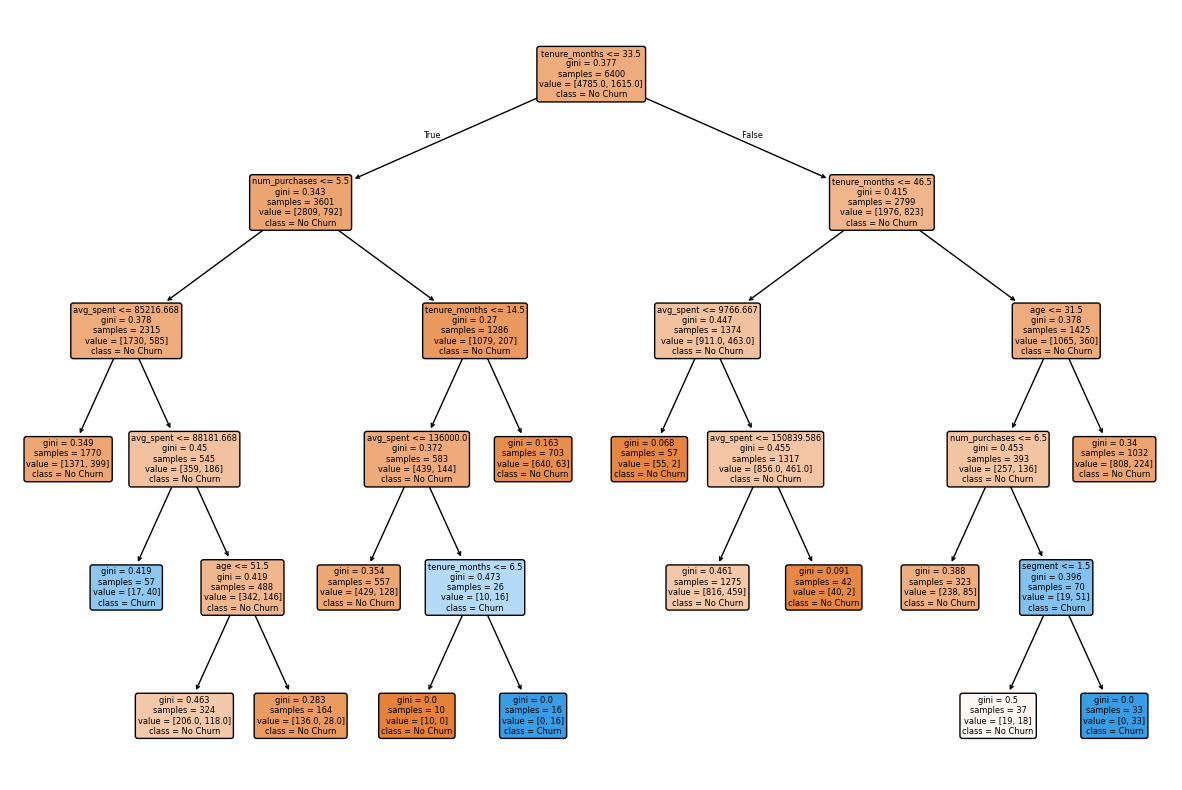

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("customer_intelligence_dataset.csv")

# Encode categorical features
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['sentiment'] = df['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})

# Encode region and segment using LabelEncoder
for col in ["region", "segment"]:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # ensure string
        df[col] = le.fit_transform(df[col])

# Ensure churn is numeric
df['churn'] = df['churn'].map({0: 0, 1: 1})

# Feature engineering
df['num_purchases'] = df.groupby('customer_id')['sale_id'].transform('count')
df['avg_spent'] = df.groupby('customer_id')['total_value'].transform('mean')

# Feature set
features = ["age", "gender", "region", "segment", "tenure_months", 
            "num_purchases", "avg_spent", "sentiment"]

# Replace NaN with 0 instead of dropping all
df_model = df[features + ["churn"]].fillna(0)

X = df_model[features]
y = df_model["churn"]

# If still empty, check size
print("Dataset size after preprocessing:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision tree with pre-pruning
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,             # limit tree depth
    min_samples_split=20,    # min samples to split
    min_samples_leaf=10,     # min samples at leaf
    max_leaf_nodes=15,       # limit max leaves
    random_state=42
)

dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot tree
plt.figure(figsize=(15, 10))
plot_tree(dt, feature_names=features, class_names=["No Churn", "Churn"], filled=True, rounded=True)
plt.show()


Accuracy: 0.748730964467005

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86       295
           1       0.00      0.00      0.00        99

    accuracy                           0.75       394
   macro avg       0.37      0.50      0.43       394
weighted avg       0.56      0.75      0.64       394



c:\Users\kashmala.arif\OneDrive - Incedo Technology Solutions Ltd\Documents\Capstone Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kashmala.arif\OneDrive - Incedo Technology Solutions Ltd\Documents\Capstone Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kashmala.arif\OneDrive - Incedo Technology Solutions Ltd\Documents\Capstone Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defin

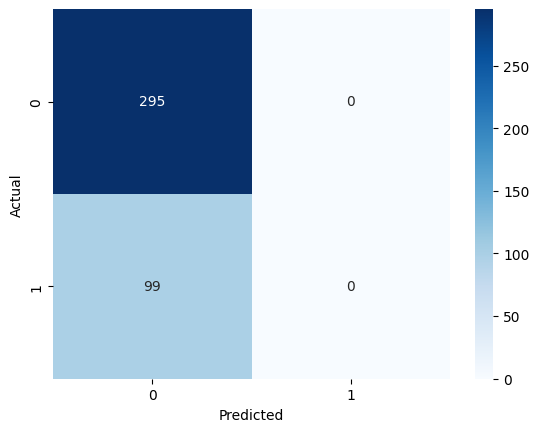

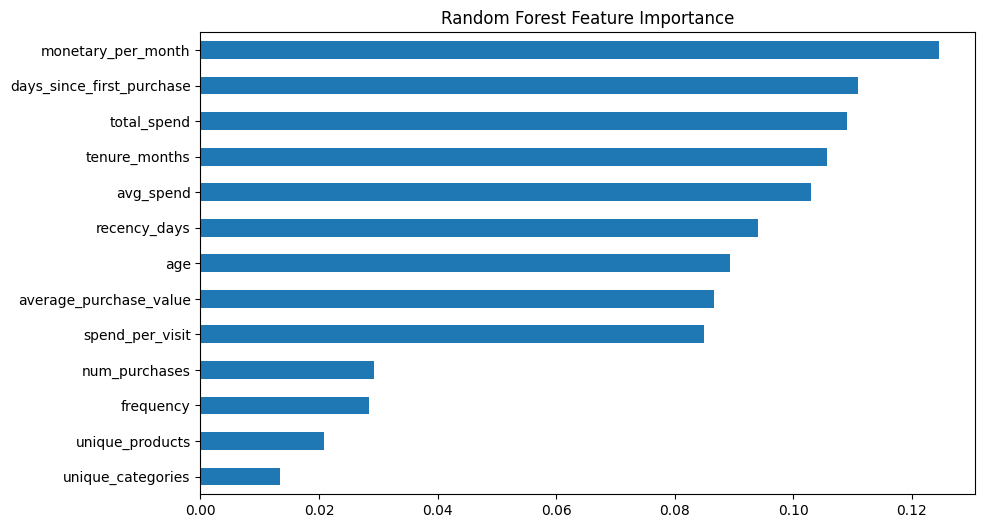

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("customer_cleaned.csv")

# -------------------------------
# Feature Engineering
# -------------------------------
customer_summary = df.groupby("customer_id").agg({
    "sale_id": "count",
    "total_value": "sum",
    "price": "mean",
    "product_id": pd.Series.nunique,
    "category": pd.Series.nunique,
    "last_purchase_date": "max",
    "age": "last",
    "tenure_months": "last",
    "churn": "first"
}).reset_index()

customer_summary.rename(columns={
    "sale_id": "purchase_frequency",
    "total_value": "total_spend",
    "price": "avg_spend",
    "product_id": "unique_products",
    "category": "unique_categories"
}, inplace=True)

# Add num_purchases
customer_summary["num_purchases"] = customer_summary["purchase_frequency"]

# Average quantity per customer
avg_quantity = df.groupby("customer_id")["quantity"].mean()
customer_summary = customer_summary.merge(avg_quantity, on="customer_id", how="left")
customer_summary.rename(columns={"quantity": "avg_quantity"}, inplace=True)

# Convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])
last_date = df['sale_date'].max()

# Recency in days
recency = df.groupby("customer_id")["sale_date"].max().apply(lambda x: (last_date - x).days)
customer_summary["recency_days"] = recency.values

# Spend per month & per visit
customer_summary["spend_per_month"] = customer_summary["total_spend"] / customer_summary["tenure_months"].replace(0, 1)
customer_summary["spend_per_visit"] = customer_summary["total_spend"] / customer_summary["purchase_frequency"].replace(0, 1)

# Frequency, average purchase value, days since first purchase, monetary per month
customer_summary["frequency"] = customer_summary["num_purchases"].astype(int)
customer_summary['average_purchase_value'] = (
    customer_summary["total_spend"] / customer_summary["num_purchases"].replace(0, 1)
)
first_purchase = df.groupby("customer_id")["sale_date"].min()
customer_summary["days_since_first_purchase"] = (last_date - first_purchase).dt.days.values
customer_summary["monetary_per_month"] = customer_summary["total_spend"] / (customer_summary["tenure_months"].replace(0, 1))

# Handle NaN/Inf globally
customer_summary = customer_summary.replace([np.inf, -np.inf], np.nan).fillna(0)

# -------------------------------
# Only numeric features
# -------------------------------
numeric_features = [
    "frequency", "total_spend", "avg_spend",
    "unique_products", "unique_categories", "recency_days",
    "age", "tenure_months", "num_purchases",
    "spend_per_visit", "average_purchase_value",
    "days_since_first_purchase", "monetary_per_month"
]

X = customer_summary[numeric_features]
y = customer_summary["churn"]

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
importances = pd.Series(rf.feature_importances_, index=numeric_features).sort_values(ascending=True)
importances.plot(kind='barh', figsize=(10,6), title="Random Forest Feature Importance")
plt.show()

